# Redes Feed Forward

Implementação da previsão do consumo de cimento nos estados  do Brasil utilizando redes neurais multi layer perceptrons feed forward

> Dados utilizados disponíveis em: `https://github.com/LeiteJu/TCC/blob/main/dados/input/df.csv`

Modelo:
- Treinamento: dados de 01/2003 até 06/2017
- Teste: dados de 07/2017 até 12/2019

Experimentos:
- camadas: 1,2,3,4
- standard scaler, minmax scaler, power transformer, batch normalization
- função de ativação relu e swish
- epochs: 100, 200, 300, 400


Melhores resultados: 

|      | MLP |
|------|------------------|
| RMSE | 35724.18         |
| MAE  | 23680.35         |
| MAPE | 0.30             |

Config:

4 camadas com ativação relu e units (256, 128, 64, 32) e minmax

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.random import set_seed

sns.set_palette("Set2")

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")

from keras.layers import BatchNormalization

# Constantes

In [30]:
# path dos dados 
PATH="https://raw.githubusercontent.com/LeiteJu/TCC/main/dados/input/"

#siglas dos estados
SIGLAS = ['AC', 'AL', 'AM', 'AP', 'BA', 'CE',
  'DF', 'ES', 'GO', 'MA',
  'MG', 'MS', 'MT', 'PA', 'PB',
  'PE', 'PI', 'PR', 'RJ',
  'RN', 'RO', 'RR', 'RS',
  'SC', 'SE', 'SP', 'TO']

# categorias
LABELS=["subestima: -90%", "subestima entre -90% e 60%", "subestima entre -60% e -30%",
        "subestima entre -30% e 10%", "entre -10% e 10%", "superestima entre 10% e 30%", 
        "superestima entre 30% e 60%", "superestima entre 60% e 90%", "superestima mais de 90%"]

# regioes
N='NORTE'
NE="NORDESTE"
CO='CENTRO OESTE'
SE='SUDESTE'
S = 'SUL'

REGIOES = {
    'AC': N, 'AL': NE, 'AM' : N, 'AP' : N, 'BA' : NE, 'CE' : NE,
    'DF' : CO, 'ES' : SE, 'GO' : CO, 'MA' : NE,
    'MG' : SE, 'MS' : CO, 'MT' : CO, 'PA' : N, 'PB' : NE,
    'PE' : NE, 'PI' : NE, 'PR' : S, 'RJ' : SE,
    'RN' : NE, 'RO' : N, 'RR' : N, 'RS' : S,
    'SC' : S, 'SE' : NE, 'SP' : SE, 'TO' : N}

In [31]:
# calcula metricas de regressao
def score_regression_metrics(y_test, y_test_pred):

    RMSE = mean_squared_error(y_true=y_test, y_pred=y_test_pred, squared=False)
    MAE = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
    MAPE = mean_absolute_percentage_error(y_true=y_test, y_pred=y_test_pred)
    R2 = r2_score(y_true=y_test, y_pred=y_test_pred)

    scores = {
        "rmse": RMSE,
        "mae": MAE,
        "mape": MAPE,
    }

    return scores

# mostra as metricas de regressao 
def show_scores (scores):

    print ("Scores obtidos:")

    print (f"RMSE: {scores['rmse']}")
    print (f"MAE: {scores['mae']}")
    print (f"MAPE: {scores['mape']}")

In [32]:
# classifica o input de acordo com a categoria 
def categorize(x):
    if x < - 0.9:
        return LABELS[0]
    elif x < - 0.6:
        return LABELS[1]
    elif x < - 0.3:
        return LABELS[2]
    elif x < - 0.1:
        return LABELS[3]
    elif x < 0.1:
        return LABELS[4]
    elif x < 0.3:
        return LABELS[5]
    elif x < 0.6:
        return LABELS[6]
    elif x < 0.9:
        return LABELS[7]
    else:
        return LABELS[8]

In [115]:
# mostra os deltas percentuais 
def show_delta (y_test, y_pred):
    
    data=(y_pred - y_test)/y_test

    error = pd.DataFrame(data, columns=['erro'])
    error['categoria']=error['erro'].apply(categorize)
    
    plt.figure(figsize=(30,10))

    g = sns.countplot(data=error, x='categoria', order=LABELS)
    
    plt.show()
    
    return error

In [34]:
def get_regiao (x):
    return REGIOES[x]

In [35]:
# separa y_test e y_pred em dados por estado e ao longo do tempo
def get_pred (y_test, y_pred):
    
    # os testes sao realizados com dados de 07/2017 ate 12/2019
    init = pd.to_datetime("072017", format='%m%Y')
    end = pd.to_datetime("122019", format='%m%Y')
    data = pd.date_range(start=init, end=end, freq='MS').date
    
    # todas as datas se repetem para cada estado
    pred = pd.DataFrame(list(data) * 27, columns=['data']).sort_values('data')
    
    # todos os estados se repetem para cada data
    pred['estados'] = SIGLAS * 30
    
    # garante que todos os estados estao presentes em todas as datas 
    pred['y_test'] =  y_test[len(y_test) % 27 :].values
    pred['y_pred'] = y_pred[len(y_pred) % 27 :]
    
    pred = pred.set_index('data')
    
    pred['regiao'] = pred['estados'].apply(get_regiao)
    
    return pred

# SEED

In [36]:
def set_seeds (SEED=41):
    os.environ['PYTHONHASHSEED'] = str(SEED)
    set_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)
    
SEED = 41
set_seeds(SEED)

# Dados

In [37]:
def load_data():
    
    df = pd.read_csv(f"{PATH}df.csv")
    
    x  = df.copy()
    x = x.sort_values(["data", "estados"])
    x = x.drop(["consumo", 'data'], axis=1)

    y = df.copy().sort_values(["data", "estados"])[['estados', 'data', 'consumo']]
    
    # processo de one-hot
    x = pd.get_dummies(data=x, columns=["estados"], drop_first=True)

    y = y['consumo']
    
    return x,y

# Experimentos

## 1 camada de 16 neurônios

### Standard scaler

In [74]:
SEED = 41
set_seeds(SEED)

x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=16, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 246994.5583123613
MAE: 147465.818026902
MAPE: 0.9471601454914635
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 205140.496369055
MAE: 128625.65212503685
MAPE: 0.8810699978948591


In [105]:
SEED = 41
set_seeds(SEED)

x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=16, activation="swish")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 3ms/step
Scores obtidos:
RMSE: 254081.95320263677
MAE: 151779.9180326292
MAPE: 0.9649249459128793
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 214653.4424103397
MAE: 135373.85180562813
MAPE: 0.9224306393300179


### minmax scaler

In [39]:
SEED = 41
set_seeds(SEED)

x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=16, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 252380.9841974362
MAE: 139685.8936822227
MAPE: 0.7674769773737242
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 215460.1433149431
MAE: 125583.7221095167
MAPE: 0.6903443206639711


In [104]:
SEED = 41
set_seeds(SEED)

x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=16, activation="swish")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 1s 3ms/step
Scores obtidos:
RMSE: 260965.92367683726
MAE: 151129.96923115055
MAPE: 0.8474293929785185
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 225154.80504469282
MAE: 138142.19248849852
MAPE: 0.8130759874777613


Text(0.5, 1.0, 'RMSE')

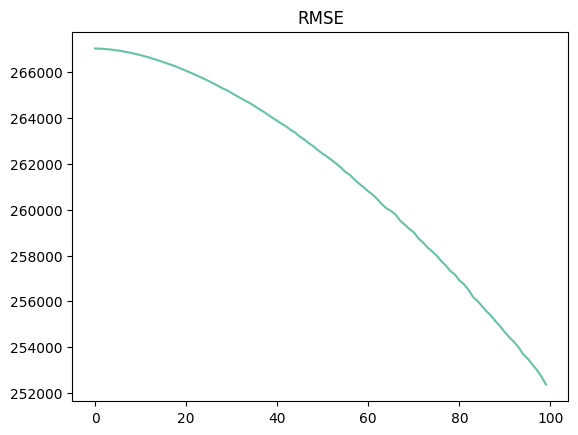

In [40]:
plt.plot(history.history["RMSE"])
plt.title("RMSE")

In [75]:
SEED = 41
set_seeds(SEED)

x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=16, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=200, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 233500.98777418854
MAE: 118161.73185849379
MAPE: 0.8476686063874663
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 194531.54137898856
MAE: 105798.21763527811
MAPE: 0.798937166175736


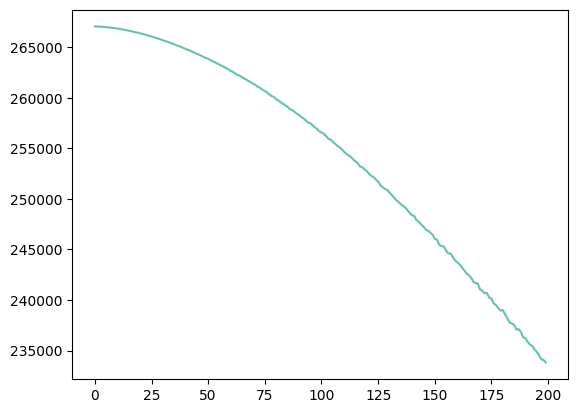

In [76]:
plt.plot(history.history["RMSE"])


In [77]:
SEED = 41
set_seeds(SEED)

x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=16, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=300, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 206446.48858670497
MAE: 103851.86367004913
MAPE: 1.4195813224560534
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 166855.00279208625
MAE: 97897.91974947098
MAPE: 1.4807951848059766


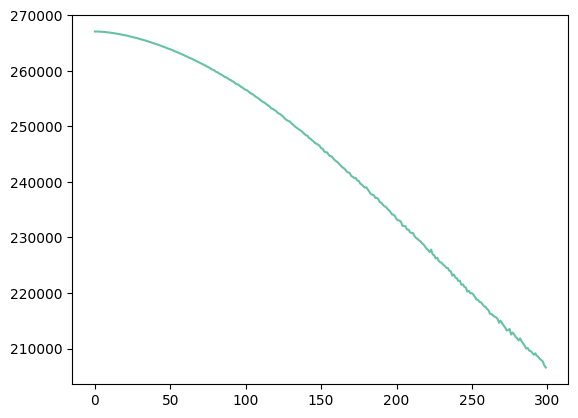

In [78]:
plt.plot(history.history["RMSE"])

### power transformer

In [79]:
SEED = 41
set_seeds(SEED)
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = PowerTransformer()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=16, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 243668.070346667
MAE: 142943.69034150202
MAPE: 0.921303883964837
26/26 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 200478.87945015295
MAE: 121374.88123709576
MAPE: 0.82028383600386


## 1 camada de 32 neurônios

In [80]:
SEED = 41
set_seeds(SEED)

x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 222601.70439661364
MAE: 131845.4192205303
MAPE: 0.8733174232566095
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 172732.71367219443
MAE: 105484.41255123988
MAPE: 0.743507213047091


## 2 camadas (64, 32)

### standard scaler

In [81]:
SEED = 41
set_seeds(SEED)

x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 43234.08848191169
MAE: 27438.796667561204
MAPE: 0.3390893468339197
26/26 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 72458.49565878542
MAE: 41818.332888620505
MAPE: 0.45657084584847435


In [106]:
SEED = 41
set_seeds(SEED)

x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=64, activation="swish")),
model.add(Dense(units=32, activation="swish")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 43874.01147442378
MAE: 29626.09911105148
MAPE: 0.4139202255823243
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 66849.10567019039
MAE: 40796.97807895287
MAPE: 0.49174642594935114


In [107]:
SEED = 41
set_seeds(SEED)

x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="swish")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 43559.204584482504
MAE: 27664.63381893194
MAPE: 0.3446902078511403
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 72734.04802530278
MAE: 41758.173577932524
MAPE: 0.4576251100980315


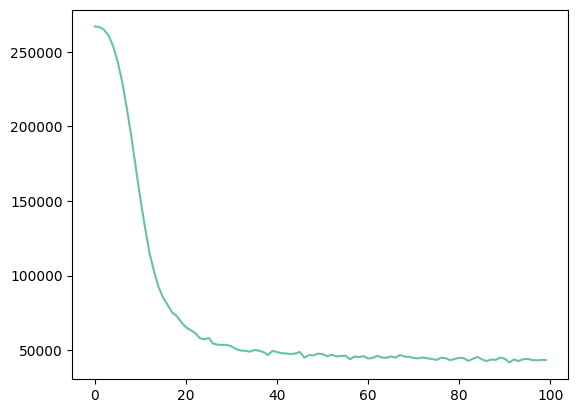

In [48]:
plt.plot(history.history["RMSE"])

In [108]:
SEED = 41
set_seeds(SEED)

x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=64, activation="swish")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 41203.63456575886
MAE: 25321.319228879227
MAPE: 0.298645624969276
26/26 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 70901.85925986936
MAE: 37985.259258302554
MAPE: 0.38317590042429805


In [110]:
SEED = 41
set_seeds(SEED)

x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=64, activation="swish")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=200, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 31851.82967031392
MAE: 19193.599925149178
MAPE: 0.2536142599037495
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 59281.51288038393
MAE: 35853.73675776969
MAPE: 0.4403449770033048


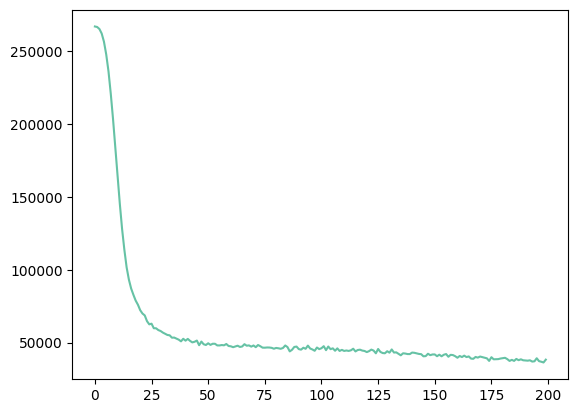

In [111]:
plt.plot(history.history["RMSE"])

In [82]:
SEED = 41
set_seeds(SEED)

x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 1s 3ms/step
Scores obtidos:
RMSE: 40494.09732749083
MAE: 22217.887951908102
MAPE: 0.24526011933124153
26/26 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 85639.71661513812
MAE: 51961.29415432285
MAPE: 0.6319710833726611


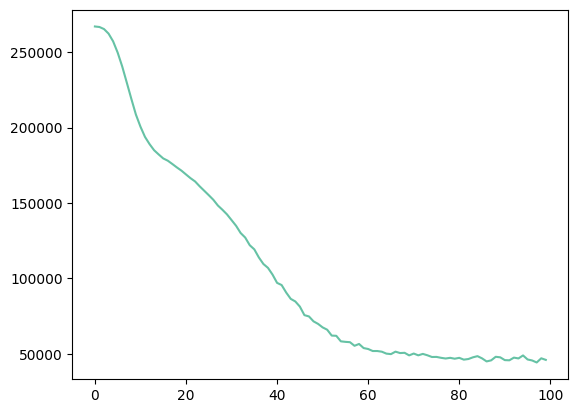

In [83]:
plt.plot(history.history["RMSE"])


## 3 camadas (128, 64, 32)

### StandardScaler

In [84]:
SEED = 41
set_seeds(SEED)

x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 27777.314510258304
MAE: 15499.373290036468
MAPE: 0.1710180245682718
26/26 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 42505.92214955561
MAE: 29389.273809467577
MAPE: 0.4905411987726513


### MinMax Scaler

In [85]:
SEED = 41
set_seeds(SEED)

x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 33733.21700086493
MAE: 18782.349826009984
MAPE: 0.2081434682493984
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 68387.62999329923
MAE: 38005.39286684269
MAPE: 0.3908992873608126


## 3 camadas (256, 128, 64)

### Standard Scaler

In [86]:
SEED = 41
set_seeds(SEED)

x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 25416.804526208027
MAE: 13560.797683412624
MAPE: 0.1366149916929172
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 39428.41451740916
MAE: 25624.154694821267
MAPE: 0.4075806310859518


### MinMax Scaler

#### 100 epochs

In [87]:
SEED = 41
set_seeds(SEED)

x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 28925.672281313695
MAE: 16560.850810986653
MAPE: 0.1749235098246903
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 54502.268477392354
MAE: 33483.57239197589
MAPE: 0.39636612583462916


#### 200 epochs

In [88]:
SEED = 41
set_seeds(SEED)

x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=200, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 25267.77452219119
MAE: 13490.446583111916
MAPE: 0.12359371408045046
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 36758.21401216493
MAE: 23704.126089924048
MAPE: 0.3115730916575525


#### 300 epochs

In [89]:
SEED = 41
set_seeds(SEED)

x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=300, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 23475.437160835165
MAE: 12551.137752898603
MAPE: 0.12043715750807911
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 37347.650800844945
MAE: 24986.247638301087
MAPE: 0.36256679475926795


#### 400 epochs

In [90]:
SEED = 41
set_seeds(SEED)


x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=400, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 22421.84353153655
MAE: 11553.54462784937
MAPE: 0.10721543575876004
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 38286.57378706087
MAE: 24549.264071002115
MAPE: 0.35297471118043683


## 4 camadas (256, 128, 64, 32)

### Standard Scaler

#### 100 epochs

In [91]:
SEED = 41
set_seeds(SEED)

x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 27659.6548137836
MAE: 14307.427658092693
MAPE: 0.12430383340462078
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 39152.281716784986
MAE: 26131.654850693394
MAPE: 0.43056381738423105


### MinMax Scaler

#### 100 epochs

In [92]:
SEED = 41
set_seeds(SEED)

x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 28898.996588938502
MAE: 17160.251471848882
MAPE: 0.1828036456184894
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 45864.59732691072
MAE: 29472.23298632104
MAPE: 0.36943942089955417


#### 200 epochs <- melhor

model.add(Dense(units=256, activation="swish")),
model.add(Dense(units=128, activation="swish")),
model.add(Dense(units=64, activation="swish")),
model.add(Dense(units=32, activation="swish")),

In [113]:
SEED = 41
set_seeds(SEED)

x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="swish")),
model.add(Dense(units=128, activation="swish")),
model.add(Dense(units=64, activation="swish")),
model.add(Dense(units=32, activation="swish")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=200, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 24662.462205780543
MAE: 14255.874019494533
MAPE: 0.15902319609908813
26/26 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 40111.72122615334
MAE: 23781.75262620919
MAPE: 0.23878239249925137


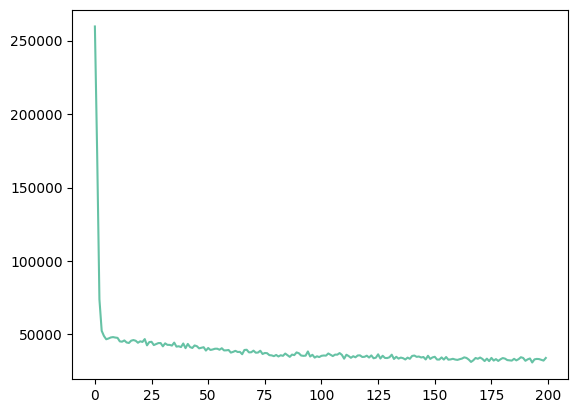

In [114]:
plt.plot(history.history["RMSE"])

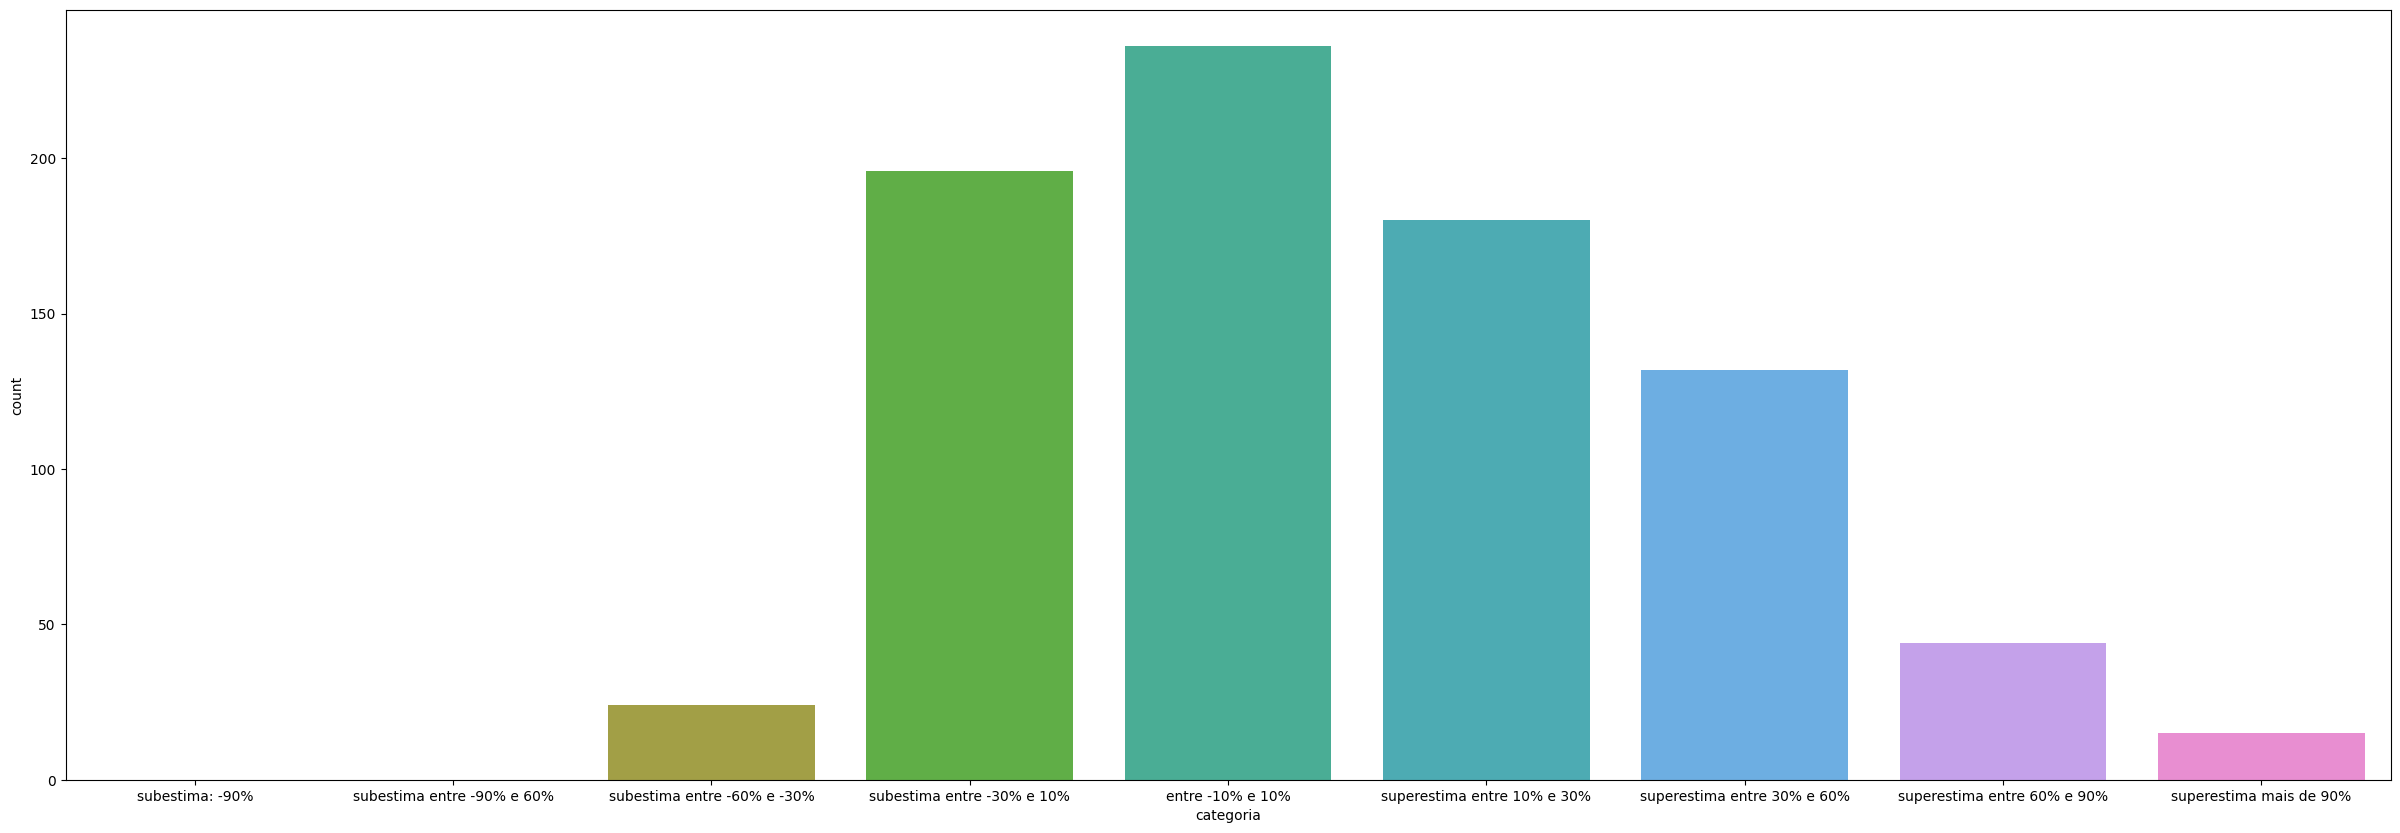

In [116]:
err = show_delta(np.array(y_test), y_pred.flatten())

In [118]:
err['categoria'].value_counts()

entre -10% e 10%               236
subestima entre -30% e 10%     196
superestima entre 10% e 30%    180
superestima entre 30% e 60%    132
superestima entre 60% e 90%     44
subestima entre -60% e -30%     24
superestima mais de 90%         15
Name: categoria, dtype: int64

In [119]:
pred=get_pred(y_test, y_pred)

In [120]:
df = pd.read_csv(f"{PATH}df.csv")
pred = pred.reset_index()
df=df[["data","estados", "consumo"]]
pred['data'] = pd.to_datetime(pred['data'])

In [122]:
df['data'] = pd.to_datetime(df['data'])
resultados=pd.merge(df,pred[["data","y_pred","estados"]].sort_values(["data",'estados']), on=["data", "estados"], how="left")
resultados = resultados.rename({'y_pred':'previsão', 'consumo':"dado real"}, axis=1)
resultados=resultados.set_index('data')

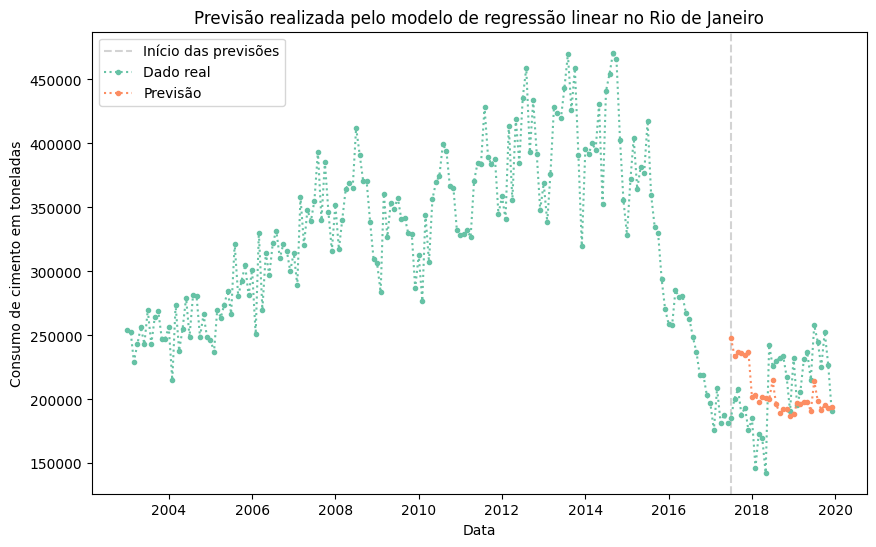

In [123]:
plt.figure(figsize=(10,6))

plt.title("Previsão realizada pelo modelo de regressão linear no Rio de Janeiro")

plt.axvline(x=pd.to_datetime("2017-07-01"), color='lightgray', linestyle="--", label="Início das previsões")

plt.plot(resultados[resultados['estados'] == "RJ"]['dado real'], linestyle=":", marker=".", label="Dado real")
plt.plot(resultados[resultados['estados'] == "RJ"]['previsão'], linestyle=":", marker=".", label="Previsão")

plt.xlabel("Data")
plt.ylabel("Consumo de cimento em toneladas")

plt.legend()

plt.show()


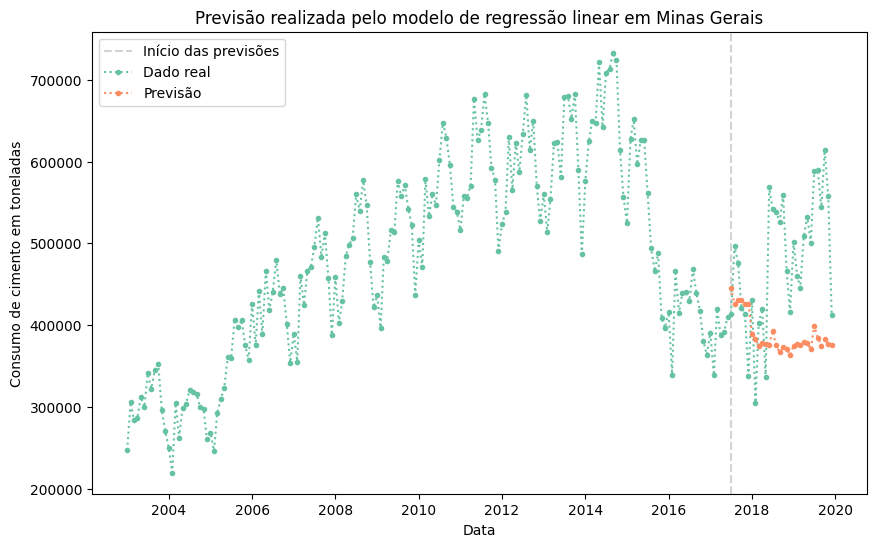

In [124]:
plt.figure(figsize=(10,6))

plt.title("Previsão realizada pelo modelo de regressão linear em Minas Gerais")

plt.axvline(x=pd.to_datetime("2017-07-01"), color='lightgray', linestyle="--", label="Início das previsões")

plt.plot(resultados[resultados['estados'] == "MG"]['dado real'], linestyle=":", marker=".", label="Dado real")
plt.plot(resultados[resultados['estados'] == "MG"]['previsão'], linestyle=":", marker=".", label="Previsão")

plt.xlabel("Data")
plt.ylabel("Consumo de cimento em toneladas")

plt.legend()

plt.show()


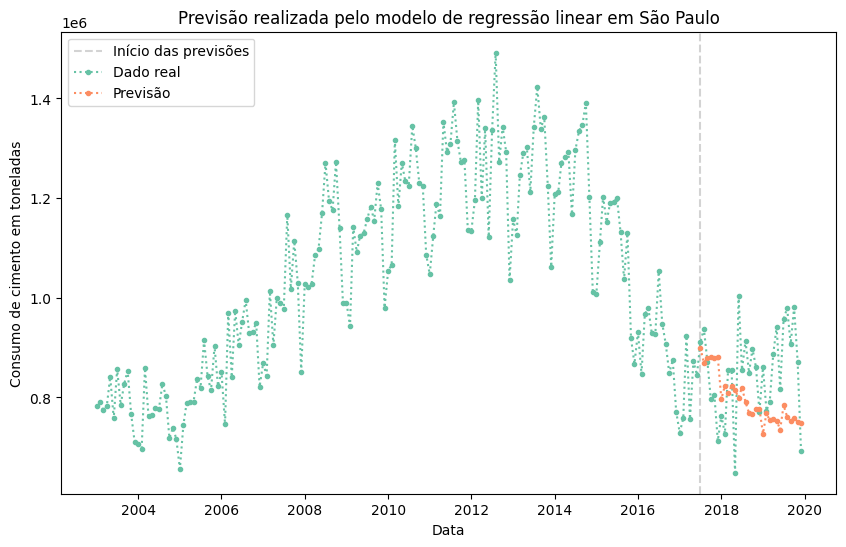

In [125]:
plt.figure(figsize=(10,6))

plt.title("Previsão realizada pelo modelo de regressão linear em São Paulo")

plt.axvline(x=pd.to_datetime("2017-07-01"), color='lightgray', linestyle="--", label="Início das previsões")

plt.plot(resultados[resultados['estados'] == "SP"]['dado real'], linestyle=":", marker=".", label="Dado real")
plt.plot(resultados[resultados['estados'] == "SP"]['previsão'], linestyle=":", marker=".", label="Previsão")

plt.xlabel("Data")
plt.ylabel("Consumo de cimento em toneladas")

plt.legend()

plt.show()


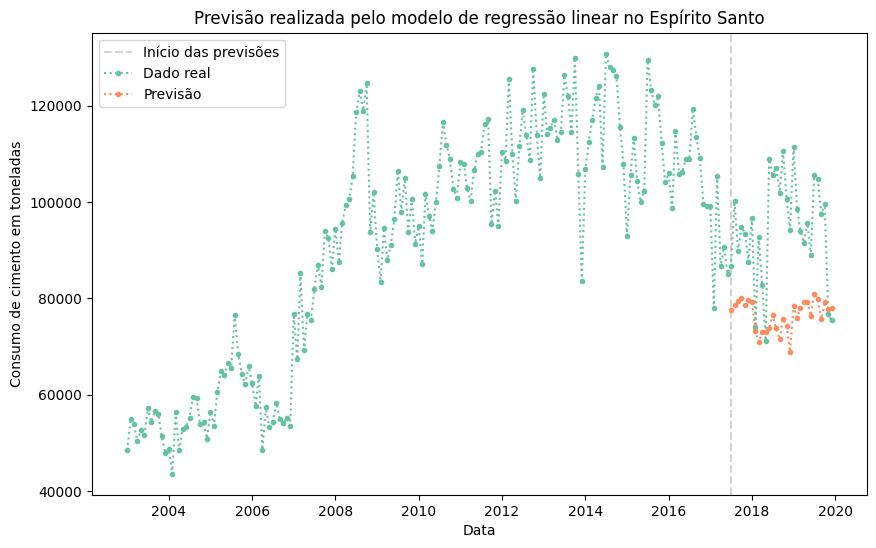

In [126]:
plt.figure(figsize=(10,6))

plt.title("Previsão realizada pelo modelo de regressão linear no Espírito Santo")

plt.axvline(x=pd.to_datetime("2017-07-01"), color='lightgray', linestyle="--", label="Início das previsões")

plt.plot(resultados[resultados['estados'] == "ES"]['dado real'], linestyle=":", marker=".", label="Dado real")
plt.plot(resultados[resultados['estados'] == "ES"]['previsão'], linestyle=":", marker=".", label="Previsão")

plt.xlabel("Data")
plt.ylabel("Consumo de cimento em toneladas")

plt.legend()

plt.show()


In [112]:
SEED = 41
set_seeds(SEED)

x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="swish")),
model.add(Dense(units=128, activation="swish")),
model.add(Dense(units=64, activation="swish")),
model.add(Dense(units=32, activation="swish")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=200, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 18432.895908428436
MAE: 9686.04726208676
MAPE: 0.09021761109791888
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 60429.579763747926
MAE: 34686.906475542244
MAPE: 0.3298898123578981


In [102]:
SEED = 41
set_seeds(SEED)

x,y = load_data()

DROP=['pib_pc',  'selic', 'idh_e', 'idh_l', 'nfsp', 'preco_ton', 'estoque']
x=x.drop(DROP, axis=1)

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=200, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 1s 3ms/step
Scores obtidos:
RMSE: 31637.418570385875
MAE: 18165.87270929188
MAPE: 0.1647065038450888
26/26 [==============================] - 0s 3ms/step
Scores obtidos:
RMSE: 50331.446154943755
MAE: 30614.152908786466
MAPE: 0.312381065987445


In [ ]:
x,y = load_data()

DROP=['pib_pc',  'selic', 'idh_e', 'idh_l', 'nfsp', 'preco_ton', 'estoque']
x=x.drop(DROP, axis=1)

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=200, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

#### 300 epochs

In [94]:
SEED = 41
set_seeds(SEED)

x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=300, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 24058.469175938637
MAE: 12946.959133228911
MAPE: 0.12498033406958575
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 38989.79415838892
MAE: 25900.9779688917
MAPE: 0.3491962631100976


In [95]:
SEED = 41
set_seeds(SEED)
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=512, activation="relu")),
model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 27490.836793591476
MAE: 14388.918095995195
MAPE: 0.12618815116864102
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 39765.61443043236
MAE: 25701.472346867442
MAPE: 0.3458011084481464


In [96]:
SEED = 41
set_seeds(SEED)

x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=512, activation="relu")),
model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=300, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 25446.68520915647
MAE: 13260.98297602321
MAPE: 0.11319898344805916
26/26 [==============================] - 0s 3ms/step
Scores obtidos:
RMSE: 42287.99771883312
MAE: 27311.910724238587
MAPE: 0.3493175074303858


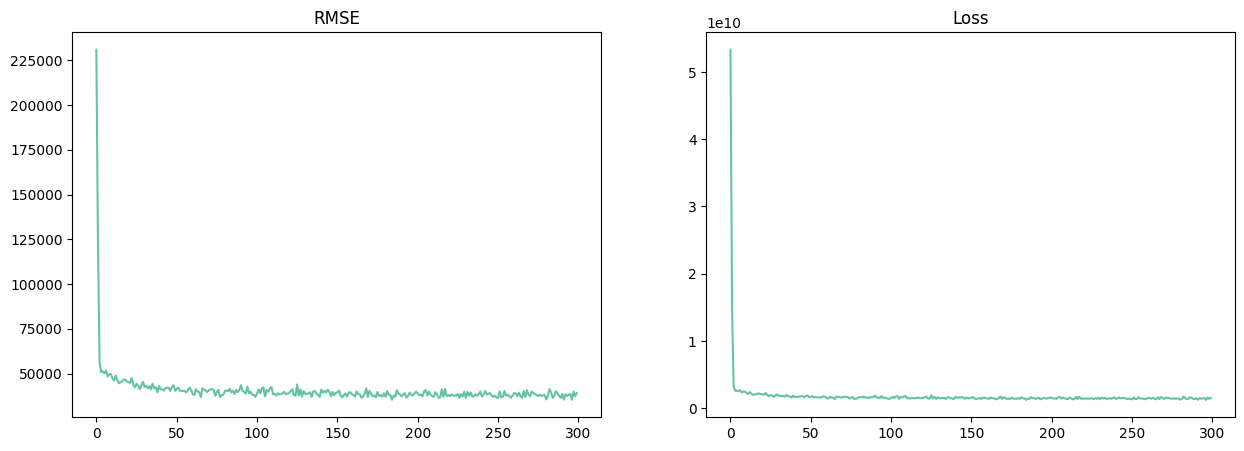

In [65]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

plt.plot(history.history["RMSE"])
plt.title("RMSE")

plt.subplot(1,2,2)

plt.plot(history.history["loss"])
plt.title("Loss")

plt.show()

In [97]:
SEED = 41
set_seeds(SEED)

x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=64, activation="swish")),
model.add(Dense(units=32, activation="swish")),
model.add(Dense(units=16, activation="swish")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 37492.822305779104
MAE: 21481.88904243709
MAPE: 0.24428649500088773
26/26 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 60473.77829966131
MAE: 35855.27558900771
MAPE: 0.5071809978549898


### Swish

In [98]:
SEED = 41
set_seeds(SEED)

x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=64, activation="swish")),
model.add(Dense(units=64, activation="swish")),
model.add(Dense(units=64, activation="swish")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 33667.62008507053
MAE: 20776.301430545645
MAPE: 0.2794649521326552
26/26 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 53078.17458577963
MAE: 34001.35316845526
MAPE: 0.5253458039912045


In [100]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="swish")),
model.add(Dense(units=64, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 30163.748136371556
MAE: 16704.495422858865
MAPE: 0.15337866215835802
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 62722.16832250593
MAE: 36271.93060856257
MAPE: 0.3718674269775936


# Gráficos

In [101]:
set_seeds(41)

x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=200, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 23947.58892952416
MAE: 12980.706076447674
MAPE: 0.11790089218171701
26/26 [==============================] - 0s 3ms/step
Scores obtidos:
RMSE: 36728.66449340107
MAE: 23880.638820662032
MAPE: 0.3122620981950407


In [70]:
pred = get_pred(y_test, y_pred)

In [ ]:
show_delta(np.array(y_test), y_pred.flatten())

In [ ]:
#Best: -53222.032266 using {'model__activation': 'relu', 'model__batch_size': 32, 'model__dropout_rate': 0.1, 'model__epochs': 200, 'model__learning_rate': 0.001, 'model__n_layers': 3, 'model__n_units': 64}


In [99]:
SEED = 41
set_seeds(SEED)

x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=64, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=200, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 26295.24143645042
MAE: 14147.014983083209
MAPE: 0.13060453323562352
26/26 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 44269.907666541905
MAE: 27095.937381915053
MAPE: 0.31038842308362524


In [ ]:
pred = get_pred(y_test, y_pred)

In [ ]:
def region_graphs (pred, reg):
    
    plt.figure(figsize=(14,6))
        
    plt.title(f"Visão regional: {reg}")
    
    pred=pred[pred['regiao'] == reg]
    
    plt.ylabel="Consumo"
    sns.scatterplot(pred, x=pred.index, y='y_test', hue="estados")
    sns.lineplot(pred, x=pred.index, y='y_pred', hue="estados")
    
#     for state in reg:
        
#         sns.scatterplot(pred[pred['estados'] == state]['y_test'], label=f"Dado real de {state}")
#         sns.lineplot(pred[pred['estados'] == state]['y_pred'], label=f"Previsão e {state}")
        
    plt.show()

In [ ]:
region_graphs(pred, 'SUDESTE')

In [ ]:
region_graphs(pred, 'NORDESTE')

In [ ]:
def region_metrics (pred):

    for reg in pred['regiao'].unique():
        
        print (f"Metricas de {reg}:")
        print (f"RMSE: {mean_squared_error(pred[pred['regiao'] == reg]['y_test'], pred[pred['regiao'] == reg]['y_pred'], squared=False)}")
        print (f"MAPE: {mean_absolute_percentage_error(pred[pred['regiao'] == reg]['y_test'], pred[pred['regiao'] == reg]['y_pred'])}")
        print (f"MAE: {mean_absolute_error(pred[pred['regiao'] == reg]['y_test'], pred[pred['regiao'] == reg]['y_pred'])}")
        print ("-------------------------------\n")

In [ ]:
region_metrics(pred)